Machine perceptual quality evaluation

* Images
  * Dataset: [ImageNet-1k](https://huggingface.co/datasets/imagenet-1k)
  * Model: [Distilled data-efficient Image Transformer (DeiT)](https://huggingface.co/facebook/deit-small-distilled-patch16-224)
  * Metric: Image classification accuracy
  * Compression:
    * JPEG Q=5/100
    * HIFIC
    * TFCI
* Audio
  * Dataset: [Common Voice Corpus 11.0](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0)
  * Model: [Whisper](https://huggingface.co/openai/whisper-small)
  * Metric: Speech recognition word error rate
  * Compression:
    * MP3 kbps
    * Descript
    * Encodec 

In [48]:
from datasets import load_dataset
import PIL
import torchaudio
import evaluate
from evaluate import evaluator
from transformers import pipeline
from io import BytesIO
import encodec
import torch
import numpy as np
from compressai.zoo import bmshj2018_factorized
from torchvision import transforms

In [2]:
def jpeg_compress_quality_5(sample):
    img = sample['image']
    with BytesIO() as f:
        img.save(f, format='JPEG',quality=5)
        img = f.getvalue()
    sample['image'] = img
    return sample

In [3]:
net = bmshj2018_factorized(quality=2, pretrained=True).eval()
def rdae_compress(sample):
    img = sample['image']

    if (img.mode == 'L') | (img.mode == 'CMYK') | (img.mode == 'RGBA'):
        rgbimg = PIL.Image.new("RGB", img.size)
        rgbimg.paste(img)
        img = rgbimg

    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad():
        out_net = net.forward(x)
    out_net['x_hat'].clamp_(0, 1)
    sample['image'] = transforms.ToPILImage()(out_net['x_hat'].squeeze())

    return sample

Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-2-87279a02.pth.tar" to /home/dan/.cache/torch/hub/checkpoints/bmshj2018-factorized-prior-2-87279a02.pth.tar
100%|██████████████████████████| 11.5M/11.5M [00:02<00:00, 5.51MB/s]


In [4]:
def mp3_compress_quality_8(sample):
    try:
        audio = sample['audio']['array'].unsqueeze(0)
        fs = sample['audio']['sampling_rate']
        with BytesIO() as f:
            torchaudio.save(f, audio, sample_rate=fs, format="mp3", compression=8)
            f.seek(0)
            audio = torchaudio.load(f,format="mp3")
        sample['audio']['array'] = audio[0][0]
    except:
        pass
    return sample

In [5]:
model = encodec.EncodecModel.encodec_model_48khz()
model.set_target_bandwidth(3)

def encodec_compress(sample):
    audio = sample['audio']['array'].unsqueeze(0)
    fs = sample['audio']['sampling_rate']
    audio = encodec.utils.convert_audio(audio,fs,model.sample_rate,model.channels)
    with torch.no_grad():
        encoded_frames = model.encode(audio.unsqueeze(0))
        sample['audio']['array'] = model.decode(encoded_frames).mean(dim=[0,1]) 
    return sample

In [6]:
data = load_dataset("imagenet-1k", split="validation[:100]")
jpeg_q5 = data.map(jpeg_compress_quality_5)
rdae = data.map(rdae_compress)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [7]:
pipe = pipeline(
    task="image-classification",
    model="facebook/deit-small-distilled-patch16-224"
)

task_evaluator = evaluator("image-classification")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [8]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=data,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.81,
 'total_time_in_seconds': 2.0621120198629797,
 'samples_per_second': 48.49397076238596,
 'latency_in_seconds': 0.020621120198629796}

In [9]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=jpeg_q5,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.7,
 'total_time_in_seconds': 1.8150526769459248,
 'samples_per_second': 55.09481970973081,
 'latency_in_seconds': 0.018150526769459246}

In [10]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=rdae,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.78,
 'total_time_in_seconds': 2.293169038835913,
 'samples_per_second': 43.60777522566031,
 'latency_in_seconds': 0.02293169038835913}

In [11]:
data = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="validation[:40]")
mp3_q8 = data.with_format("torch").map(mp3_compress_quality_8).with_format('numpy')
encodec_q48 = data.with_format("torch").map(encodec_compress).with_format("numpy")

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

/home/dan/.local/lib/python3.10/site-packages/torchaudio/backend/sox_io_backend.py:416: UserWarning: File-like object support in sox_io backend is deprecated, and will be removed in v2.1. See https://github.com/pytorch/audio/issues/2950 for the detail.Please migrate to the new dispatcher, or use soundfile backend.
  warnings.warn(_deprecation_message)
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG aud

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [12]:
pipe = pipeline(
    task="automatic-speech-recognition",
    model="openai/whisper-small",
)

task_evaluator = evaluator("automatic-speech-recognition")
task_evaluator.PIPELINE_KWARGS.pop('truncation', None)

True

In [13]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=data,
    input_column="audio",
    label_column="sentence",
    metric="wer",
)
eval_results

{'wer': 0.24324324324324326,
 'total_time_in_seconds': 31.928794587031007,
 'samples_per_second': 1.2527876644690932,
 'latency_in_seconds': 0.7982198646757752}

In [14]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=mp3_q8,
    input_column="audio",
    label_column="sentence",
    metric="wer",
)
eval_results

{'wer': 0.327027027027027,
 'total_time_in_seconds': 34.731284122914076,
 'samples_per_second': 1.1516994263281464,
 'latency_in_seconds': 0.8682821030728519}

In [15]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=encodec_q48,
    input_column="audio",
    label_column="sentence",
    metric="wer",
)
eval_results

{'wer': 0.5054054054054054,
 'total_time_in_seconds': 34.0187990241684,
 'samples_per_second': 1.1758204624326185,
 'latency_in_seconds': 0.85046997560421}

In [24]:
data = load_dataset("scene_parse_150",split='validation')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [21]:
pipe = pipeline(
    task="image-segmentation",
    model="nvidia/segformer-b0-finetuned-ade-512-512",
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/dan/.local/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [35]:
mean_iou = evaluate.load("mean_iou")

In [182]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

extractor = AutoFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

inputs = extractor(images=data[0]['image'], return_tensors="pt",do_resize=False)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
predictions = logits.argmax(dim=1)[0].detach().unsqueeze(0).unsqueeze(0)
resize = transforms.Resize((375,500),antialias=True)
predictions = resize(predictions)[0][0]

/home/dan/.local/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/dan/.local/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


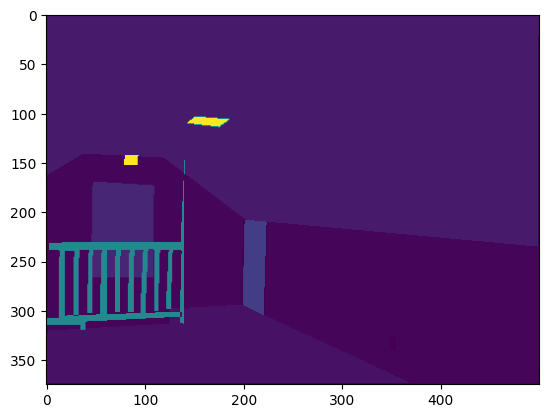

In [183]:
ground_truth = np.array(data[0]['annotation'])
plt.imshow(ground_truth)

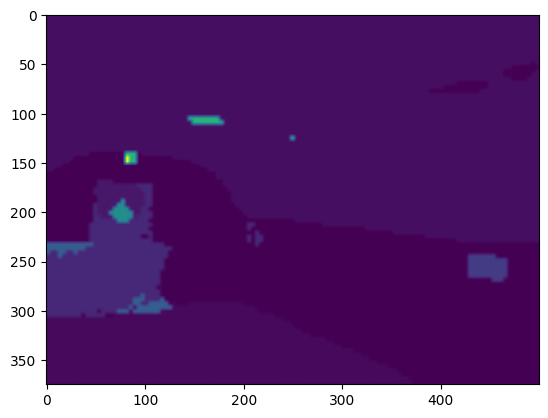

In [184]:
plt.imshow(predictions)

In [194]:
mean_iou.compute(
    predictions=np.array(predictions),
    references=np.array(ground_truth),
)

ValueError: Predictions and/or references don't match the expected format.
Expected format: {'predictions': Sequence(feature=Sequence(feature=Value(dtype='uint16', id=None), length=-1, id=None), length=-1, id=None), 'references': Sequence(feature=Sequence(feature=Value(dtype='uint16', id=None), length=-1, id=None), length=-1, id=None)},
Input predictions: [[5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]],
Input references: [[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [4 4 4 ... 1 1 1]
 [4 4 4 ... 1 1 1]
 [0 0 0 ... 0 0 0]]